# Weight range target

Example for 5 units into the future. 

Price example for 10 units: 10, 12, 13, 16, 17, 16, 13, 10, 8, 5

At 10 units, next 5 are 12, 13, 16, 17, 16. Want 16 reduced to 10. Solution: Take difference:

At 10 units, next 5 are 2, 3, 6, 7, 6. (5-pos)/5 weight for each value. 

Highest weighted value - lowest weight value is value proposition (vp). 

Plan: 

map(lambda x, p: ((n-p)/n) * x, list[x], range(len(list(x))))

Then map relative strength using log: ln(vp)/ln(close)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import usefulfunctions as uf
from ta.trend import SMAIndicator

In [2]:
df = pd.read_csv("../data/BTCUSDT-hour-test-all-features.csv")

In [31]:
def get_target(df, span=200):
    """gets the balanced value proposition (highest gain over next 200 - lowest low)"""
    acc = []
    df_len = len(df["close"])

    for i in range(len(df["close"])):

        if i+span < df_len:
            close = df["close"].iloc[i]
            c = df["close"][i:i+span]
            a = list(map(lambda x: x-close, c))
            b = list(map(lambda x, p: ((span-p)/span)*x, a, range(span)))
            
            acc.append(uf.log_abs(max(b) + min(b), zeros=True)/uf.log_abs(close))
        else:
            acc.append(None)

    return acc

def get_sma_rate(df, span=50):
    """returns sma rate list"""
    sma_i = SMAIndicator(close=df["close"], window=span)
    sma = sma_i.sma_indicator()
    past = sma.shift(1)
    return list(map(uf.none_subtraction, sma, past))

def dissuade_from_buying_up(df, span=50, limit=0):
    """prevents buying when span sma's slope is greater than limit"""
    df["sma_rate"] = get_sma_rate(df, span)
    return list(map(lambda sma, t: t if sma<limit else -1,df["sma_rate"], df["target"]))

def classify(df, limit:float):
    """return 1 if value is above limit, else 0"""
    return list(map(lambda x: 0 if x<limit else 1, df["target"]))


In [32]:
df["target"] = get_target(df)
df["target"] = dissuade_from_buying_up(df, 50, 0)
df["target"] = classify(df, 0.7)
# df["target"] = dissuade_from_buying_up(df, 20, 0)

In [55]:
df.to_csv("../data/BTCUSDT-hour-target-classification.csv", index=False)

In [53]:
dp = df[3000:5000]
print(df.iloc[3000]["timestamp"])

2017-12-23 10:00:00.000


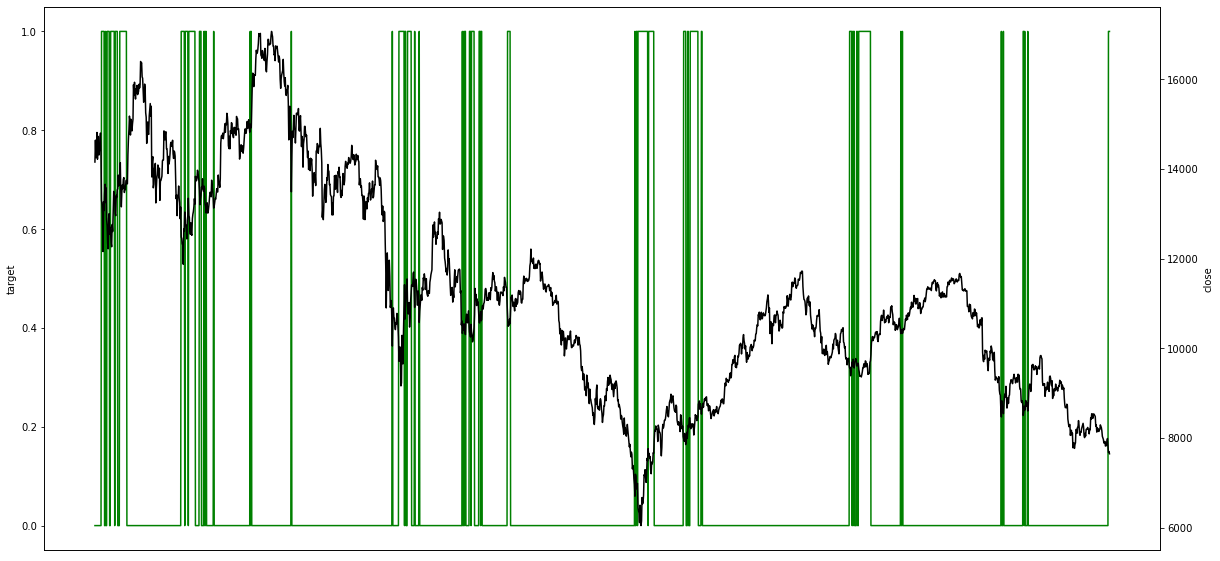

In [54]:
fig,ax = plt.subplots(figsize=(20, 10))
ax.plot(dp.timestamp,
        dp.target,
        color="green")
# ax.axhline(y=0, color='darkgreen', linestyle='-')
ax.set_xlabel("time")
ax.set_ylabel("target")

ax.tick_params(labelbottom=False)    
ax.axes.xaxis.set_visible(False)

ax2=ax.twinx()
ax2.plot(dp.timestamp,
         dp.close,
         color="black")

ax2.set_ylabel("close")
# fig.legend(["a", "b", "c", "d"])
plt.show()